In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict, Annotated
from dotenv import load_dotenv
import operator
from pydantic import BaseModel, Field
load_dotenv()

True

In [2]:
model = ChatGroq(model='openai/gpt-oss-120b')
model

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000023A315F8B10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000023A31748910>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
class EvaluationSchema(BaseModel):
    feedback : str = Field(description='Detailed feedback for the essay')
    score : float = Field(description='Score out of 10', gt=0, lt=10)

In [4]:
structured_model = model.with_structured_output(EvaluationSchema)

In [5]:
essay = """ 
The rise of Artificial Intelligence (AI) is one of the most transformative developments of the 21st century. From voice assistants and recommendation systems to self-driving cars and advanced medical diagnostics, AI has rapidly shifted from theory to everyday reality. Its growth is fueled by vast amounts of data, powerful computing resources, and breakthroughs in machine learning models that can mimic aspects of human reasoning.

AI is revolutionizing industries by improving efficiency, automating routine tasks, and uncovering insights once hidden in complex datasets. In healthcare, it aids in detecting diseases earlier and tailoring treatments. In business, it enhances decision-making and customer experiences. Yet, this rise also brings challenges—ethical concerns, job displacement, and questions about accountability.

Ultimately, the rise of AI is both exciting and demanding. How society manages its benefits and risks will determine whether it becomes a force for broad progress or deep division.
"""

In [6]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"

In [7]:
structured_model.invoke(prompt).score

8.5

In [8]:
class UPSCState(TypedDict):

    essay               : str
    language_feedback   : str
    analysis_feedback   : str
    clearity_feedback   : str
    overall_feedback    : str
    individual_score   : Annotated[list[float], operator.add]
    avg_score           : float



In [9]:
def evaluate_language(state : UPSCState):

    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    return {'language_feedback' : output.feedback, 'individual_score' : [output.score]}


In [10]:
def evaluate_analysis(state : UPSCState):

    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    return {'analysis_feedback' : output.feedback, 'individual_score' : [output.score]}


In [11]:
def evaluate_tought(state : UPSCState):

    prompt = f"Evaluate the clearity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)
    return {'clearity_feedback' : output.feedback, 'individual_score' : [output.score]}


In [15]:
def final_evaluation(state : UPSCState):
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clearity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    avg_score = sum(state["individual_score"]) / len(state["individual_score"])
    return {'overall_feedback':overall_feedback, 'avg_score' : avg_score}

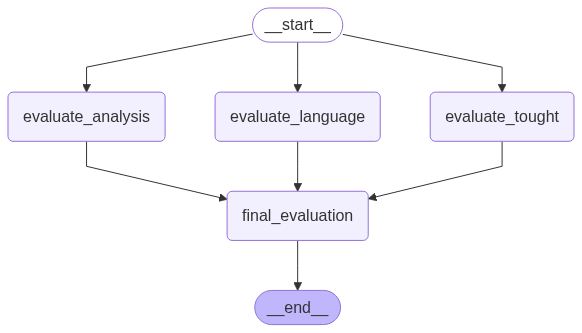

In [17]:
graph = StateGraph(UPSCState)

graph.add_node('evaluate_language'  ,     evaluate_language)
graph.add_node('evaluate_analysis'  ,     evaluate_analysis)
graph.add_node('evaluate_tought'    ,       evaluate_tought)
graph.add_node('final_evaluation'   ,      final_evaluation)

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_tought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_tought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()
graph.compile()

In [18]:
initial_state = {'essay' : essay}
final_state = workflow.invoke(initial_state)
final_state

{'essay': ' \nThe rise of Artificial Intelligence (AI) is one of the most transformative developments of the 21st century. From voice assistants and recommendation systems to self-driving cars and advanced medical diagnostics, AI has rapidly shifted from theory to everyday reality. Its growth is fueled by vast amounts of data, powerful computing resources, and breakthroughs in machine learning models that can mimic aspects of human reasoning.\n\nAI is revolutionizing industries by improving efficiency, automating routine tasks, and uncovering insights once hidden in complex datasets. In healthcare, it aids in detecting diseases earlier and tailoring treatments. In business, it enhances decision-making and customer experiences. Yet, this rise also brings challenges—ethical concerns, job displacement, and questions about accountability.\n\nUltimately, the rise of AI is both exciting and demanding. How society manages its benefits and risks will determine whether it becomes a force for br